# RecoNet: Using Neural Networks to Reconstruct Phaseless Spectrograms
This notebook is a first attempt at implementing a reconstructing neural network for recovering audio sounds from magnitude spectrograms only. This is all in hopes of building generative models for audio sounds.

In [19]:
%matplotlib inline
import IPython.display

# Set GPU Usage
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import gzip
import cPickle as pickle
import seaborn as sns
import random
import librosa
import sklearn

# Keras Imports
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, Bidirectional
from keras.layers import Flatten, Reshape, TimeDistributed
from keras.layers.recurrent import GRU, LSTM
from keras import backend as K
from keras.callbacks import TensorBoard

from librosa.display import waveplot, specshow
sns.set(style='ticks')
# seaborn.set(style='white')

## Loading Data

In [2]:
# Loaded Spoken Digits Dataset
dbfile ='../SpokenDigitDB.pkl.gz'
with gzip.open(dbfile, 'rb') as ifile:
    df = pickle.load(ifile)
    print('File loaded as '+ dbfile)

df.head(n=3)    

File loaded as ../SpokenDigitDB.pkl.gz


,Class,Magnitude,PShift,Phase,SIndex,TStretch,Wave
0,0,"[[-22.0287, -39.3797, -19.2818, -19.0951, -51....",-1,"[[0.0, -3.14159, -3.14159, -3.14159, -3.14159,...",0,0.75,"[-0.00708008, -0.0124207, -0.011322, -0.014526..."
1,0,"[[-21.268, -32.4348, -30.0193, -20.2256, -21.6...",0,"[[0.0, 0.0, -3.14159, -3.14159, -3.14159, -3.1...",0,0.75,"[-0.0102234, -0.0121155, -0.0131531, -0.015747..."
2,0,"[[-21.2643, -27.9082, -28.497, -33.7005, -36.5...",1,"[[0.0, 0.0, 0.0, -3.14159, -3.14159, -3.14159,...",0,0.75,"[-0.0127563, -0.0126343, -0.0152283, -0.017486..."


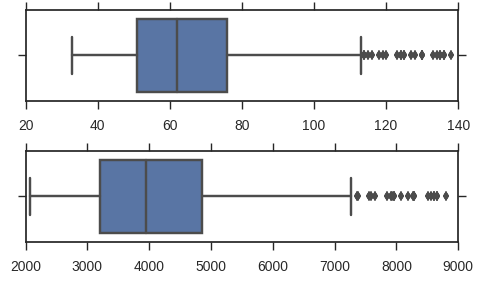

In [3]:
# Distribution of Audio Duration
a = [np.shape(x)[1] for x in df.Magnitude]
b = [np.shape(x) for x in df.Wave]

plt.figure(figsize=(5,3))
plt.subplot(211)
sns.boxplot(a)

plt.subplot(212)
sns.boxplot(b)
plt.tight_layout()

In [5]:
y = df.Wave[404][:4096]
s = librosa.stft(y,n_fft=128-1,hop_length=64)
s.shape  #(64, 80)

(64, 64)

In [6]:
# Padding & Truncating
smax = 64#80    # Max number of frames in STFT
wmax = 4096#5120  # Corresponding max number of samples
spad = lambda a, n: a[:,0: n] if a.shape[1] > n else np.hstack((a, np.min(a[:])*np.ones([a.shape[0],n - a.shape[1]])))
wpad = lambda a, n: a[:n] if a.shape[0] > n else np.append(a,np.zeros(n-a.shape[0]))

df.Magnitude = df.Magnitude.apply(spad,args=(smax,))  # MaxLen Truncation Voodoo :D
df.Wave      = df.Wave.apply(wpad,args=(wmax,))

print(np.unique([np.shape(x)[1] for x in df.Magnitude]))
print(np.unique([np.shape(x)[0] for x in df.Wave]))

[64]
[4096]


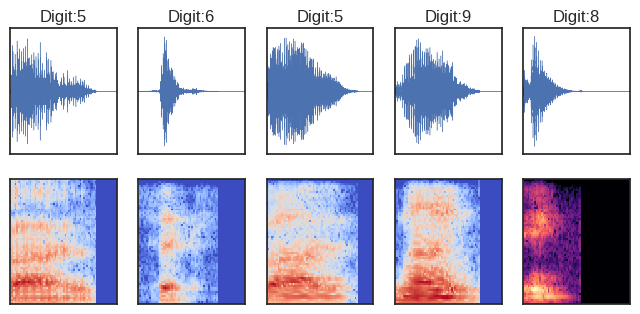

In [7]:
# Plot K Random Examples
k  = 5
sr = 8000

sidx = random.sample(range(len(df)),k)
sidx = np.append(sidx,sidx)    

sns.set(style='white')
for i,j in enumerate(sidx):
    if i<k:
        plt.subplot(3,k,i+1)
        waveplot(df.Wave[j],sr=sr)
        plt.title('Digit:{1}'.format(j,df.Class[j]))
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().get_xaxis().set_visible(False)

    else:
        plt.subplot(3,k,i+1)
        specshow(df.Magnitude[j],sr=sr)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])

In [8]:
# Play back an example!
j = sidx[1]
IPython.display.Audio(data=df.Wave[j], rate=sr)

## Data Prep

In [9]:
# Prepare Data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_validation import train_test_split

# Randomize DataFrame
df = df.sample(frac=1,random_state=32)

# Train Scaler
x_data = df.Magnitude.values
normsc = np.hstack(x_data)
scaler = MinMaxScaler().fit(normsc.T)

# Transform Data using Scaler
x_data = [scaler.transform(arr.T).T for arr in df.Magnitude.values]
x_data = np.dstack(x_data).transpose(2,1,0)


# Target Data (Decoder)
y_data = df.Wave.values             # Get waveform vectors
y_data = np.vstack(y_data)          # Stack to obtain 2D array of waveforms
ndim   = (y_data.shape[0],smax,-1)    # Reshape into Windows of length 80 (smax)
y_data = y_data.reshape(ndim)       # Use .Flatten() to recover

# Decoder Input Data (same as target, with offset 1 in time)
d_data = np.zeros_like(y_data)      
d_data[:,0, :] = 1.                 # Start Token: [1,1,1...1]
d_data[:,1:,:] = y_data[:,:-1,:]    # Decoder Input = Target plus 1 timestep: t + 1


# # Shuffle & Split
x_train,x_test,y_train,y_test,d_train,d_test=train_test_split(
    x_data,y_data,d_data,test_size=0.1, random_state=32)

# Print Dimensions
print 'Training Feature size:', x_train.shape
print 'Training D-Input size:', d_train.shape
print 'Training Target  size:', y_train.shape
print ''
print 'Testing  Feature size:', x_test.shape
print 'Testing  D-Input size:', d_test.shape
print 'Testing  Target  size:', y_test.shape

Training Feature size: (4058, 64, 64)
Training D-Input size: (4058, 64, 64)
Training Target  size: (4058, 64, 64)

Testing  Feature size: (451, 64, 64)
Testing  D-Input size: (451, 64, 64)
Testing  Target  size: (451, 64, 64)


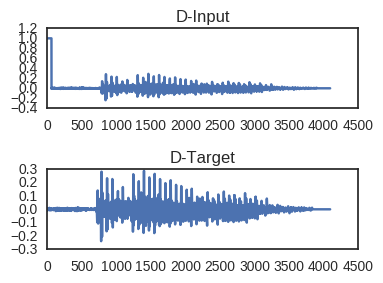

In [10]:
# Testing Decoder Target & Input
plt.figure(figsize=(4,3))
plt.subplot(211)
plt.title('D-Input')
plt.plot(d_data[0].flatten())

plt.subplot(212)
plt.title('D-Target')
plt.plot(y_data[0].flatten())
plt.tight_layout()

## Sequence-To-Sequence Model

In [18]:
# Parameters
frms,fbns  = x_train.shape[1:]   # FFT bins and frames in spectrogram
specg_size = (frms,fbns)         # Input spectrogram size
nspf       = y_train.shape[2]    # Number of samples per frame in output

E1  = 128
E2  = smax  #TODO verify
D1  = E2
D2  = 128

### Model

In [15]:
# x = Input(shape=specg_size,name='E-Input')
# h = GRU(E1,return_sequences=True,name='E1')(x)
# h = GRU(E2,return_sequences=True,name='E2')(h)
# h = GRU(D1,return_sequences=True,name='D1')(h)
# h = GRU(D2,return_sequences=True,name='D2')(h)
# y = GRU(nspf,return_sequences=True,name='Output')(h)

# model = Model(x,y)
# model.summary()
# model.compile(optimizer='adam',
#                 loss='mean_squared_error')

In [16]:
# # Train Model
# log = model.fit(x_train, y_train,
#               batch_size=100,
#               epochs=100,
# #               validation_split=0.2,
#               initial_epoch=0)

In [17]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14490907606711325552
]


In [37]:
# Encoder
x      = Input(shape=specg_size,name='E-Input')
e1     = Bidirectional(GRU(E1/2,return_sequences=True,name='E1'))(x)
encode = GRU(E2,return_state='True',name='E2')
_,este = encode(e1)       # discard encoder output, use only state

In [38]:
# Decoder
d       = Input(shape=(None,nspf),name='D-Input')
decode1 = GRU(D1,return_sequences=True,return_state=True,name='D1')
d1,_    = decode1(d,initial_state=este)
decode2 = Bidirectional(GRU(D2/2,return_sequences=True,name='D2'))
d2      = decode2(d1)
dout    = Bidirectional(GRU(nspf/2,return_sequences=True,name='Output'))
y       = dout(d2)

In [39]:
model = Model([x,d],y)
model.summary()
model.compile(optimizer='adam',
                loss='mean_squared_error')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
E-Input (InputLayer)             (None, 64, 64)        0                                            
____________________________________________________________________________________________________
bidirectional_10 (Bidirectional) (None, 64, 128)       49536       E-Input[0][0]                    
____________________________________________________________________________________________________
D-Input (InputLayer)             (None, None, 64)      0                                            
____________________________________________________________________________________________________
E2 (GRU)                         [(None, 64), (None, 6 37056       bidirectional_10[0][0]           
___________________________________________________________________________________________

In [ ]:
# Train Model
log = model.fit([x_train, d_train], y_train,
              batch_size=20,
              epochs=60,
#               validation_split=0.2,
              initial_epoch=0)

Train on 3246 samples, validate on 812 samples
Epoch 2/60
3246/3246 [==============================] - 23s - loss: 0.0042 - val_loss: 0.0022
Epoch 3/60
3246/3246 [==============================] - 21s - loss: 0.0013 - val_loss: 7.7894e-04
Epoch 4/60
3246/3246 [==============================] - 22s - loss: 6.2250e-04 - val_loss: 5.0179e-04
Epoch 5/60
3246/3246 [==============================] - 21s - loss: 4.6151e-04 - val_loss: 4.0823e-04
Epoch 6/60
3246/3246 [==============================] - 21s - loss: 3.9183e-04 - val_loss: 3.5340e-04
Epoch 7/60
3246/3246 [==============================] - 22s - loss: 3.5178e-04 - val_loss: 3.2219e-04
Epoch 8/60
3246/3246 [==============================] - 22s - loss: 3.2382e-04 - val_loss: 3.0146e-04
Epoch 9/60
3246/3246 [==============================] - 21s - loss: 3.0336e-04 - val_loss: 2.8487e-04
Epoch 10/60
3246/3246 [==============================] - 21s - loss: 2.8535e-04 - val_loss: 2.6915e-04
Epoch 11/60
3246/3246 [=======================

In [15]:
model.save('reconet_bidirect.h5')
# model = load_model('reconet_bare.h5')
# model = load_model('reconet.h5')
# decoder = load_model('inference.h5')
# model.summary()

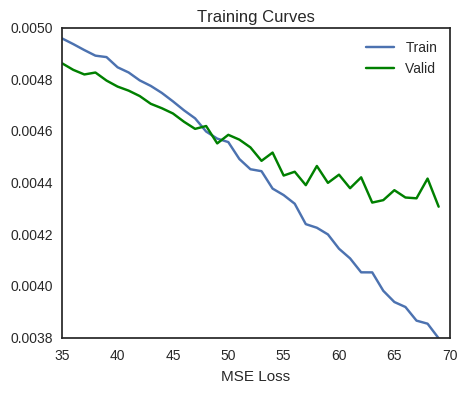

In [17]:
# Training Curves
plt.figure(figsize=(5,4))
plt.plot(log.epoch,log.history['loss'])
plt.plot(log.epoch,log.history['val_loss'],'g')
plt.title('Training Curves')
plt.xlabel('Epochs')
plt.xlabel('MSE Loss')
plt.legend(['Train','Valid'])

### Plot Predictions from Training Set

In [18]:
k   = 10
idx = random.sample(range(len(y_train)),k)

yy = y_train[idx]
yp = model.predict(x_train[idx])
# yp = model.predict([x_train[idx], d_train[idx]])

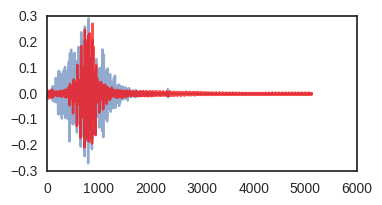

In [22]:
n=5
plt.figure(figsize=(4,2))
plt.plot(yy[n].flatten(),alpha=0.6)
plt.plot(yp[n].flatten(),'r',alpha=0.7)
# plt.subplot(211)
# plt.title('True')
# plt.plot(yy[k].flatten())

# plt.subplot(212)
# plt.title('Predicted')
# plt.plot(yp[k].flatten())
# plt.tight_layout()

In [23]:
# True
IPython.display.Audio(data=yy[n].flatten(), rate=sr)

In [24]:
# Generated
IPython.display.Audio(data=yp[n].flatten(), rate=sr)

## Inference

In [ ]:
## Sampling Model
encoder  = Model(x,este)

dste_in  = Input(shape=(D1,))
d1o,dste = decode1(d,initial_state=dste_in)
d2o      = decode2(d1o)
yd       = dout(d2o)

decoder  = Model([d,dste_in],[yd,dste])

encoder.save('encoder.h5')
decoder.save('decoder.h5')

In [ ]:
state = encoder.predict(x_test[0:1])
target = np.ones((1,1,nspf))
out, h = decoder.predict([target,state])

plt.plot(out[0,0],alpha=0.5)
plt.plot(y_test[0,0],'r',alpha=0.7)

In [ ]:
y_test.shape

In [ ]:
# Function to Decode a Sequence
def decode_seq(input_seq):
    state   = encoder.predict(input_seq)
    target  = np.ones((1,1,nspf))

    stop    = False  
    decoded = []

    while not stop:
        out, h  = decoder.predict([target,state])
        decoded.append(out.squeeze())

        target  = out
        state   = h 
        
        if (len(decoded) == 80) or (not out.any()):
            stop = True

    decoded = np.hstack(decoded)
    return decoded

In [ ]:
k  = 90
yt = y_test[k:k+1]
yp = decode_seq(yt)

plt.plot(yt.flatten(),alpha=0.5)
plt.plot(yp,'r',alpha=0.7)

In [ ]:
plt.plot(yp)

In [ ]:
IPython.display.Audio(data=yp, rate=sr)